##### Copyright 2021 The Cirq Developers

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/noise/qcvv/xeb_characterization_pipeline>"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/noise/qcvv/xeb_characterization_pipeline.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/noise/qcvv/xeb_characterization_pipeline.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/noise/qcvv/xeb_characterization_pipeline.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This notebook is a straightforward outline of how to characterize coherent error with [Cross Entropy Benchmarking (XEB)](./xeb_theory.ipynb). 

In [2]:
# @title Install `cirq_google`

try:
    import cirq
    import cirq_google
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq-google
    print("installed cirq.")
    import cirq
    import cirq_google

import numpy as np

## Set up Random Circuits

Create a library of random, two-qubit `circuits` using the `SQRT_ISWAP` gate. These library circuits will be truncated to circuits by lengths defined in  `cycle_depths`, and mixed-and-matched among all the qubit pairs on the device to be characterized.

In [3]:
from cirq.experiments import random_quantum_circuit_generation as rqcg

RANDOM_SEED = np.random.RandomState(53)
circuit_library = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20, two_qubit_gate=cirq.SQRT_ISWAP, random_state=RANDOM_SEED
)
# Will truncate to these lengths
max_depth = 100
cycle_depths = np.arange(3, max_depth, 20)

## Determine the device topology

XEB can be run on all pairs from a given device topology. The code below supplies both the `qubits` to be tested, and a `sampler` to run circuits with. By default, this sampler uses a simple `cirq.DensityMatrixSimulator` with a `cirq.ConstantQubitNoiseModel` for speed, but it also supports the [Quantum Virtual Machine](/cirq/simulate/quantum_virtual_machine) to use noise models that more closely mimic the behavior of the hardware. If you use the QVM, the sampling process will take significantly longer.

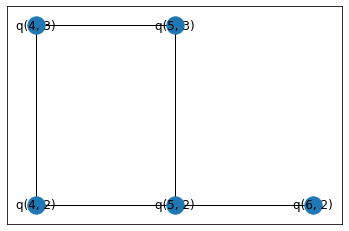

In [4]:
import networkx as nx
import itertools

# specify the qubits to be tested
qubits = cirq.GridQubit.rect(3, 2, 4, 2)
# delete one qubit from the rectangular arangement to
# 1) make it irregular 2) simplify simulation.
qubits = qubits[:-1]

processor_id = None  # 'rainbow' or 'weber' for a QVM, None for a simpler simulator
if processor_id is None:
    # create a simple constant noise model sampler
    noise_model = cirq.ConstantQubitNoiseModel(cirq.depolarize(5e-3))
    sampler = cirq.DensityMatrixSimulator(noise=noise_model)

else:
    # instantiate a QVM engine
    simulated_engine = cirq_google.engine.create_default_noisy_quantum_virtual_machine(
        processor_id=processor_id
    )

    # get the simulated device's qubits
    device_qubits = simulated_engine.get_processor(processor_id).get_device().metadata.qubit_set
    # ensure the qubits selected are a subset of the device's qubit set
    print(f"selected qubit subset is legal: {set(qubits).issubset(device_qubits)}")

    # initialize a sampler
    sampler = simulated_engine.get_sampler(processor_id)


# create a graph from adjacent qubits and draw it
graph = nx.Graph((q1, q2) for (q1, q2) in itertools.combinations(qubits, r=2) if q1.is_adjacent(q2))
pos = {q: (q.row, q.col) for q in qubits}
nx.draw_networkx(graph, pos=pos)

## Set up qubit pair combinations

XEB can be performed in a parallel or isolated manner. In the parallel case, multiple qubits are "active" to be tested simultaneously in the same circuit, where the isolated case has only one active pair running at any time. The following cell creates the `combinations_by_layer` data structure, which defines which qubit pairs are active in parallel, and which two-qubit circuits (from `circuit_library`) will be applied to each of the active pairs.

The outer list  of `combinations_by_layer` corresponds to the different layers. Each inner layer defines the `combinations` matrix, which indexes the circuit library circuits to use, and the `pairs` list, which notes which qubit pairs are active.

In [5]:
parallel = True

if parallel:
    # automatically selects multiple active pairs per layer
    combinations_by_layer = rqcg.get_random_combinations_for_device(
        n_library_circuits=len(circuit_library),
        n_combinations=10,
        device_graph=graph,
        random_state=RANDOM_SEED,
    )
else:
    # only one active pair per layer
    layer_pairs = [[pair] for pair in graph.edges]
    combinations_by_layer = rqcg.get_random_combinations_for_pairs(
        n_library_circuits=len(circuit_library),
        n_combinations=10,
        all_pairs=layer_pairs,
        random_state=RANDOM_SEED,
    )
print(len(combinations_by_layer))
combinations_by_layer[0]

4


CircuitLibraryCombination(layer=cirq.experiments.GridInteractionLayer(col_offset=0, vertical=True, stagger=True), combinations=array([[ 4],
       [15],
       [13],
       [18],
       [10],
       [12],
       [ 1],
       [ 4],
       [14],
       [17]]), pairs=[(cirq.GridQubit(4, 2), cirq.GridQubit(5, 2))])

### Visualize
Here, draw the layers' active pairs to see which qubits will be tested in which layers. The active pairs are highlighted in red, and some layers demonstrate non-overlapping qubit pairs which will be active in parallel (if using `parallel=true` above).

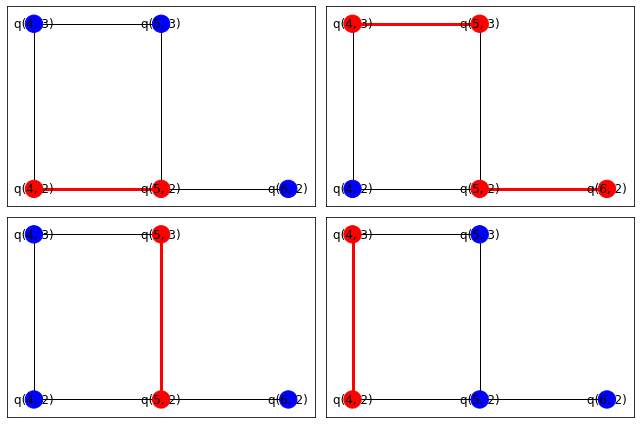

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

ncols = int(len(combinations_by_layer) ** (1 / 2))
nrows = ncols + 1 if ncols**2 < len(combinations_by_layer) else ncols
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(9, 6))
for comb_layer, ax in zip(combinations_by_layer, axes.reshape(-1)):
    active_qubits = np.array(comb_layer.pairs).reshape(-1)
    # highlight the active qubits in red
    colors = ['red' if q in active_qubits else 'blue' for q in graph.nodes]
    nx.draw_networkx(graph, pos=pos, node_color=colors, ax=ax)
    # highlight the active pair edges in red
    nx.draw_networkx_edges(
        graph, pos=pos, edgelist=comb_layer.pairs, width=3, edge_color='red', ax=ax
    )

plt.tight_layout()

## Sample Data

The sampling function `sample_2q_xeb_circuits` zips the circuits of `circuit_library` together according to `combinations_by_layer`, before sampling them and computing the sampled probabilities (`sampled_probs`) of getting the correct bit string. 

For layers with multiple active qubit pairs, it will combine the two-qubit circuits from `circuit_library` by placing different circuits on different active pairs. This creates larger, many-pair circuits, which operate on all the active pairs of a layer in parallel, without ever connecting the distinct pairs' circuits to each other. An inspection of one of the sampled `DataFrame`s reveals the available types of data, including the sampled probabilities `sampled_probs`.


In [7]:
from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits

sampled_df = sample_2q_xeb_circuits(
    sampler=sampler,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
    combinations_by_layer=combinations_by_layer,
    shuffle=RANDOM_SEED,
    repetitions=10_000,
)
sampled_df.head()

100%|█████████████████████████████████████████████████████████████████| 207/207 [00:48<00:00,  4.30it/s]


,,sampled_probs,timestamp,layer_i,pair_i,combination_i,pair
circuit_i,cycle_depth,,,,,,
2,43,"[0.1927, 0.1557, 0.2046, 0.447]",1.661069e+09,1,0,6,"(q(4, 3), q(5, 3))"
18,43,"[0.1588, 0.2612, 0.3285, 0.2515]",1.661069e+09,1,1,6,"(q(5, 2), q(6, 2))"
1,83,"[0.2148, 0.2619, 0.2488, 0.2745]",1.661069e+09,0,0,6,"(q(4, 2), q(5, 2))"
6,23,"[0.2988, 0.4275, 0.1075, 0.1662]",1.661069e+09,1,0,3,"(q(4, 3), q(5, 3))"
16,23,"[0.1652, 0.3778, 0.2316, 0.2254]",1.661069e+09,1,1,3,"(q(5, 2), q(6, 2))"


## Benchmark Fidelities

The `benchmark_2q_xeb_fidelities` function takes each sampled `DataFrame` and computes the overall fidelity across all of the randomized circuits for each qubit pair and each of the previously defined `cycle_depth`s.

In [8]:
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities

fids = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df, circuits=circuit_library, cycle_depths=cycle_depths
)
fids.head()

,layer_i,pair_i,cycle_depth,fidelity,pair
0,0,0,3,0.926841,"(q(4, 2), q(5, 2))"
1,0,0,23,0.607085,"(q(4, 2), q(5, 2))"
2,0,0,43,0.394153,"(q(4, 2), q(5, 2))"
3,0,0,63,0.263724,"(q(4, 2), q(5, 2))"
4,0,0,83,0.165376,"(q(4, 2), q(5, 2))"


## Estimate By-Layer Fidelities

Next, use `fit_exponential_decays` on each of the fidelity datasets of `circuit_fidelities`, to estimate a per-layer fidelity, which estimates the fidelity error of the two-qubit entangling gate operation on each individual qubit pair. 

In [9]:
from cirq.experiments.xeb_fitting import fit_exponential_decays, exponential_decay

fidelities = fit_exponential_decays(fids)
fidelities.head()

a  layer_fid         cycle_depths  \
layer_i pair_i pair                                                           
0       0      (q(4, 2), q(5, 2))  0.988271   0.978968  [3, 23, 43, 63, 83]   
1       0      (q(4, 3), q(5, 3))  0.996101   0.978381  [3, 23, 43, 63, 83]   
        1      (q(5, 2), q(6, 2))  0.982204   0.978875  [3, 23, 43, 63, 83]   
2       0      (q(5, 2), q(5, 3))  0.990942   0.978957  [3, 23, 43, 63, 83]   
3       0      (q(4, 2), q(4, 3))  0.985695   0.978994  [3, 23, 43, 63, 83]   

                                                                          fidelities  \
layer_i pair_i pair                                                                    
0       0      (q(4, 2), q(5, 2))  [0.926840922850544, 0.6070854252136406, 0.3941...   
1       0      (q(4, 3), q(5, 3))  [0.9313415030795407, 0.6076978439486529, 0.384...   
        1      (q(5, 2), q(6, 2))  [0.9214619253717121, 0.6039099096627306, 0.385...   
2       0      (q(5, 2), q(5, 3))  [0.9289492291571897, 0.6056305380605215, 0.405...   
3       0      (q(4, 2), q(4, 3))  [0.9241661710131125, 0.6042262943244512, 0.400...   

                                      a_std  layer_fid_std  
layer_i pair_i pair                                         
0       0      (q(4, 2), q(5, 2))  0.004043       0.000158  
1       0      (q(4, 3), q(5, 3))  0.004496       0.000178  
        1      (q(5, 2), q(6, 2))  0.006951       0.000273  
2       0      (q(5, 2), q(5, 3))  0.006751       0.000262  
3       0      (q(4, 2), q(4, 3))  0.004411       0.000172

# Visualizations

Plot the fidelity decrease per layer by qubit in a heatmap to compare the error rate per layer across different qubits. This can highlight when different qubits are performing meaningfully better or worse than the others.

/home/augusteh/.virtualenvs/cirq-py3/lib/python3.10/site-packages/cirq/vis/heatmap.py:400: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


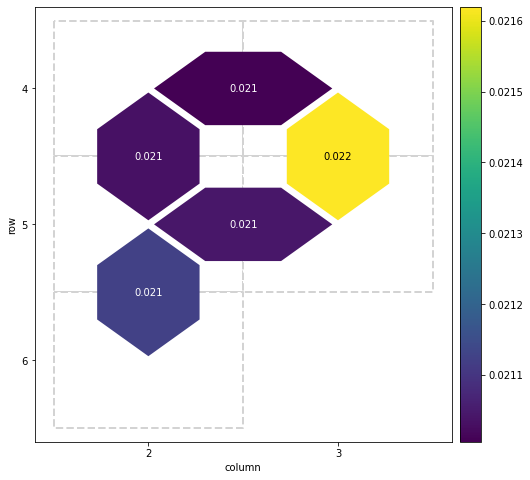

In [10]:
heatmap_data = {}

for (_, _, pair), fidelity in fidelities.layer_fid.items():
    heatmap_data[pair] = 1.0 - fidelity

cirq.TwoQubitInteractionHeatmap(heatmap_data).plot();

The qubit heatmap summarizes the data quite a lot. Plotting the fidelities by cycle depth with their fit exponential decay curves demonstrates how error accumulates when circuits get more cycles. 

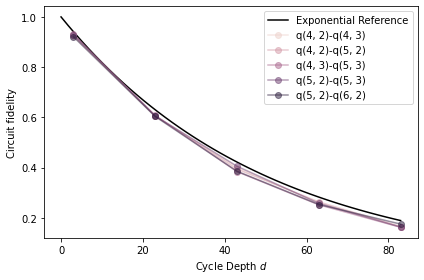

In [11]:
import seaborn as sns

# Give each pair its own color
colors = sns.cubehelix_palette(n_colors=graph.number_of_edges())
colors = dict(zip(graph.edges, colors))

# Exponential reference
xx = np.linspace(0, fids['cycle_depth'].max())
plt.plot(xx, (1 - 5e-3) ** (4 * xx), label=r'Exponential Reference', color='black')

# Plot each pair
def _p(fids):
    q0, q1 = fids.name
    plt.plot(
        fids['cycle_depth'],
        fids['fidelity'],
        'o-',
        label=f'{q0}-{q1}',
        color=colors[fids.name],
        alpha=0.5,
    )


fids.groupby('pair').apply(_p)

plt.ylabel('Circuit fidelity')
plt.xlabel('Cycle Depth $d$')
plt.legend(loc='best')
plt.tight_layout()

Included is an exponential reference line, matching the original chance of depolarization of `5e-3`. These results reinforce the idea that uniform pauli deolarization causes an exponential decay in circuit fidelity by cycle. 

## Optimize `PhasedFSimGate` parameters

In a real experiment, there is likely unknown coherent error that you would like to characterize, by identifying the true parameters of the unitary gate implemented by the hardware. To do so, make the five angles of `PhasedFSimGate` free parameters in `SqrtISwapXEBOptions`, and use a classical optimizer (`characterize_phased_fsim_parameters_with_xeb_py_pair`) to find out which set of parameters best describes the data collected from the device.

In [12]:
import multiprocessing

pool = multiprocessing.get_context('spawn').Pool()

In [ ]:
from cirq.experiments.xeb_fitting import (
    parameterize_circuit,
    characterize_phased_fsim_parameters_with_xeb_by_pair,
    SqrtISwapXEBOptions,
)

# Set which angles to characterize (all)
options = SqrtISwapXEBOptions(
    characterize_theta=True,
    characterize_zeta=True,
    characterize_chi=True,
    characterize_gamma=True,
    characterize_phi=True,
)
# Parameterize the sqrt(iswap)s in the circuit library
pcircuits = [parameterize_circuit(circuit, options) for circuit in circuit_library]

# Run the characterization loop
characterization_result = characterize_phased_fsim_parameters_with_xeb_by_pair(
    sampled_df,
    pcircuits,
    cycle_depths,
    options,
    pool=pool,
    # ease tolerance so it converges faster:
    fatol=1e-2,
    xatol=1e-2,
)

The fitting procedure finds the parameter values that are most likely to explain the data for the two-qubit unitary gate applied to each qubit pair...

In [ ]:
characterization_result.final_params

The characterization also refits the circuit fidelities by cycle, to estimate circuit performance as if the gates were performing correctly (with the correct parameters instead of those observed). 

In [ ]:
characterization_result.fidelities_df.head()

The `before_and_after_characterization` function collects the before fidelities, `circuit_fidelities`, and the after fidelities, `characterization_results` into the same data frame, by row, suffixing the data by source with `_0` and `_c` respectively. This may make it easier to plot the data by row. 

In [ ]:
from cirq.experiments.xeb_fitting import before_and_after_characterization

before_after_df = before_and_after_characterization(fids, characterization_result)
before_after_df.head()

Finally, plot the original fidelities alongside the refit fidelities, to analyze how the refitting procedure was able to identify coherent error. 

In [ ]:
for i, row in before_after_df.iterrows():
    plt.axhline(1, color='grey', ls='--')
    plt.plot(row['cycle_depths_0'], row['fidelities_0'], '*', color='red')
    plt.plot(row['cycle_depths_c'], row['fidelities_c'], 'o', color='blue')

    xx = np.linspace(0, np.max(row['cycle_depths_0']))
    plt.plot(
        xx,
        exponential_decay(xx, a=row['a_0'], layer_fid=row['layer_fid_0']),
        color='red',
        label='Original Fidelities',
    )
    plt.plot(
        xx,
        exponential_decay(xx, a=row['a_c'], layer_fid=row['layer_fid_c']),
        color='blue',
        label='Refit Fidelities',
    )

    plt.xlabel('Cycle Depth')
    plt.ylabel('Fidelity')

# make the legend labels unique
handles, labels = plt.gca().get_legend_handles_labels()
legend_items = dict(zip(labels, handles))
plt.legend(legend_items.values(), legend_items.keys(), loc='best')
plt.tight_layout()
plt.show()

The refit fidelities are almost the same as the original fidelities in this case, but are a bit better in some cases. The characterization procedure was able to identify some coherent error, but was not able to refit for all of the _incoherent_ error introduced by the depolarization. For more information on how XEB interacts with error, see [Coherent vs Incoherent Error with XEB](./coherent_vs_incoherent_xeb). 